# Inicialización

In [1]:
import numpy as np

import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import ETF_Filter as ETF

In [2]:

'''  
X <- Serie de tiempo de Ticker 1
Y <- Serie de tiempo de Ticker 2
'''

def correlation_distance(X, Y):
    cor = np.corrcoef(X,Y)[0,1]
    metrica = np.sqrt(0.5*(1-cor))
    return metrica

'''  
X <- Serie de tiempo de Ticker 1
Y <- Serie de tiempo de Ticker 2
bins <- Tamaño partición
norm <- boolean False si las series no están normalizadas
'''
#---------------------------------------------------
def varInfo(X,Y,bins,norm=False):
    import numpy as np
    # variation of information
    cXY=np.histogram2d(X,Y,bins)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=entropy(np.histogram(X,bins)[0]) # marginal
    hY=entropy(np.histogram(Y,bins)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

In [3]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2022, 6, 23)

tickers = ['ATVI', 'ADBE', 'AMD', 'ALGN', 'GOOG', 'GOOGL', 'AMZN', 'AMGN', 'ADI', 'AAPL', 'AMAT', 'ASML', 'ADSK',
    'ADP','BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 
    'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CSX', 'DXCM' ,'DOCU' ,'DLTR' ,'EBAY', 'EA' ,'EXC','EXPE','FB', 
    'FAST', 'FISV', 'FOX', 'FOXA', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG',
    'JD', 'KLAC', 'LRCX', 'LBTYA', 'LULU', 'MAR', 'MELI', 'MCHP', 'MU', 'MSFT','MRNA', 'MDLZ', 'MNST', 'NTES', 
    'NFLX' ,'NVDA', 'NXPI', 'ORLY', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST',
    'SGEN', 'SIRI', 'SWKS', 'SPLK', 'SBUX', 'SNPS', 'TMUS', 'TTWO','TSLA', 'TXN', 'KHC', 'TCOM', 
    'ULTA', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDC', 'WDAY', 'XEL', 'ZM']

# Filtro

In [4]:
class paresTrading:

    def __init__(self, tickers, start, end):

        self.start = start

        self.end = end

        self.tickers = sorted(tickers)

        # Descargar los datos y guardarlos en un dataframe que se llame self.df

        self.df = yf.download(tickers, start, end)['Adj Close'].dropna()

        self.data_filtration = self.df.copy()

        self.pairs = []

        for i in range(len(self.tickers)):
            for j in range(i+1,len(self.tickers)):
                self.pairs.append((self.tickers[i],self.tickers[j]))
                
    def TopologicalEmbedding(self, tol=100, lagtime=1):
        
        
        lista_topological = []
        lista_embedding = []
        
        for ticker in self.data_filtration.columns:
            topo = ETF.Tembedding(self.data_filtration[ticker])
            topo.tset('AAPL', lagtime)
            lista_topological.append(topo.ticker_tset)
            
            topo.tembedding()
            lista_embedding.append((ticker, topo.ticker_embedding))
        
        self.embedding_df = pd.DataFrame(lista_embedding, columns=['Ticker','Embedding']).set_index('Ticker')
        embedding_df = self.embedding_df
        
        for pair in self.pairs:
            resultado = topo.hausdorff_metric(embedding_df.loc[[pair[0]]].Embedding[0], embedding_df.loc[[pair[1]]].Embedding[0])
            if resultado > tol:
                self.pairs.remove(pair)
            
        self.__filter_data()


    def correlationTest(self, tol = 0.9):
         

        for pair in self.pairs:

                resultado = np.corrcoef(self.data_filtration[pair[0]],self.data_filtration[pair[1]])[0,1]
                if resultado < tol:

                    self.pairs.remove(pair)
            
        self.__filter_data()



    def cointegration(self, tol=0.1):

        for pair in self.pairs:

                resultado = coint(self.data_filtration[pair[0]], self.data_filtration[pair[1]])[1]

                if resultado > tol:

                    self.pairs.remove(pair)
                    
        self.__filter_data()
        
    
    def distance_correlationTest(self, tol=0.3):
        
        for pair in self.pairs:
            
            resultado = correlation_distance(self.data_filtration[pair[0]], self.data_filtration[pair[1]])
            
            if resultado > tol:
                self.pairs.remove(pair)
                
        self.__filter_data()
   
                


    def variationalInformationTest(self, bins = 50, tol = 3.0):
    
        for pair in self.pairs:

            resultado = varInfo(self.data_filtration[pair[0]],self.data_filtration[pair[1]], bins = bins)

            if resultado > tol:

                self.pairs.remove(pair)
                
        self.__filter_data()

    
    def clear_filter(self):

        self.pairs = []
        self.data_filtration = self.df.copy()

        for i in range(len(self.tickers)):
            for j in range(i+1,len(self.tickers)):
                self.pairs.append((self.tickers[i],self.tickers[j]))
            
  
    def __filter_data(self):
    
        unique_tickers = []
        
        for pair in self.pairs:
            if pair[0] not in unique_tickers:
                unique_tickers.append(pair[0])
            if pair[1] not in unique_tickers:
                unique_tickers.append(pair[1])
        
        self.data_filtration = self.data_filtration[unique_tickers]
        
    
    def plot_correlation(self, method = 'pearson', *args):
        plt.figure(figsize=(25,25))
        sns.heatmap(self.data_filtration.corr(method = method), cmap = sns.cm.rocket, *args)
        
    def plot_variational_information(self, bins= 50, *args):
        varinfo_matrix = np.zeros([self.data_filtration.shape[1], self.data_filtration.shape[1]])
        for i in range(self.data_filtration.shape[1]):
            for j in range(self.data_filtration.shape[1]):
                varinfo_matrix[i,j] = varInfo(self.data_filtration.iloc[:,i], self.data_filtration.iloc[:,j], bins = 50)
        varinfo_matrix = pd.DataFrame(varinfo_matrix, columns=self.data_filtration.columns)
        
        plt.figure(figsize=(25,25))
        sns.heatmap(varinfo_matrix, cmap = sns.cm.rocket, xticklabels=self.tickers, yticklabels=self.tickers, *args)
        
    def plot_correlationDistance(self, method = 'pearson', *args):
        
        cor = self.data_filtration.corr(method='pearson')
        metrica = np.sqrt(0.5*(1-cor))
        plt.figure(figsize=(25,25))
        sns.heatmap(metrica, cmap = sns.cm.rocket_r)
        




In [86]:
#modelo = paresTrading(tickers, start, end)

modelo.clear_filter()

In [106]:
modelo.distance_correlationTest(tol=0.2)

In [107]:
modelo.variationalInformationTest(tol = 3.5)

In [115]:
modelo.cointegration(tol=0.3)

In [123]:

modelo.TopologicalEmbedding(tol=80)


In [125]:
modelo.pairs

[('AAPL', 'AMD'),
 ('AAPL', 'CDNS'),
 ('AAPL', 'NVDA'),
 ('AAPL', 'TSLA'),
 ('ADI', 'MCHP'),
 ('AMAT', 'NXPI'),
 ('AMD', 'CDNS'),
 ('AMD', 'NVDA'),
 ('AMD', 'TSLA'),
 ('ASML', 'INTU'),
 ('AVGO', 'COST'),
 ('AVGO', 'TSLA'),
 ('CDNS', 'SNPS'),
 ('CDNS', 'TSLA'),
 ('COST', 'ORLY'),
 ('CTAS', 'MSFT'),
 ('CTAS', 'SNPS'),
 ('FAST', 'NVDA'),
 ('GOOG', 'GOOGL'),
 ('KLAC', 'SNPS'),
 ('KLAC', 'TSLA'),
 ('MCHP', 'NXPI'),
 ('MSFT', 'NVDA'),
 ('MSFT', 'SNPS'),
 ('NVDA', 'SNPS'),
 ('NVDA', 'TSLA'),
 ('NXPI', 'TXN'),
 ('SNPS', 'TSLA')]

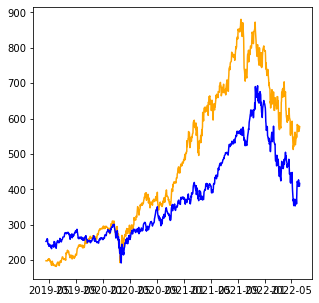

In [126]:
A = "ASML"
B = "INTU"

plt.figure(figsize=(5,5))
plt.plot(modelo.df[A], c= 'orange')
plt.plot(modelo.df[B], c='blue')

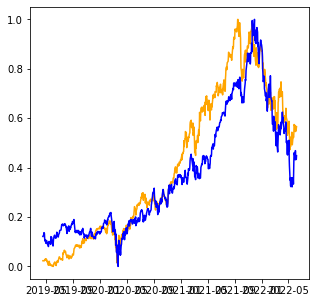

In [127]:
plt.figure(figsize=(5,5))
plt.plot((modelo.df[A]-np.min(modelo.df[A]))/(np.max(modelo.df[A]) - np.min(modelo.df[A])), c='orange')
plt.plot((modelo.df[B]-np.min(modelo.df[B]))/(np.max(modelo.df[B]) - np.min(modelo.df[B])), c="blue")
